เชื่อม google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


โหลดสิ่งที่จำเป็น

In [ ]:
!pip install -U langchain-community
# ติดตั้ง PyTorch เวอร์ชันล่าสุด
!pip install torch==2.0.1
# 🚀 ลบ PyTorch และ Transformers เก่าทั้งหมด
!pip uninstall -y torch torchvision torchaudio transformers

# 🚀 ติดตั้ง PyTorch ที่รองรับ CUDA ของ Colab (CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 🚀 ติดตั้ง Transformers เวอร์ชันที่รองรับ
!pip install transformers --upgrade


สร้าง Evaluation dataset ภาษาอังกฤษ

In [ ]:
import json
import time
import requests

# 🔑 API Key สำหรับ Together
api_key = "xxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🚀 โหลดไฟล์คำแนะนำพร้อมหมวดหมู่
embedding_file = '/content/drive/MyDrive/LockLearn/recommendations_with_categories.json'
output_file = '/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json'

with open(embedding_file, 'r', encoding='utf-8') as f:
    recommendations_with_categories = json.load(f)

# 🚀 ฟังก์ชันเรียก API เพื่อสร้างคำถาม
def request_with_retry(prompt, retries=3, delay=10):  # เรียกทีละคำขอ
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                return response.json().get("choices", [])[0]["message"]["content"]
            elif response.status_code == 429:  # ถ้าถูก rate-limited
                print("❌ Rate limit reached. Sleeping for 60 seconds...")
                time.sleep(60)  # หน่วง 60 วินาทีถ้าโดน rate limit
            else:
                print(f"❌ Error (Status {response.status_code}): {response.text}")
                time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return None

# 🚀 กรองคำแนะนำตามหมวดหมู่
category_dict = {}
for rec in recommendations_with_categories:
    category = rec.get('category', 'Unknown')
    category_dict.setdefault(category, []).append(rec)

# 🚀 เลือกคำแนะนำจากแต่ละหมวดหมู่ (สูงสุด 100)
filtered_recommendations = [rec for recs in category_dict.values() for rec in (recs if len(recs) <= 100 else random.sample(recs, 100))]

# 🚀 สร้างคำถามจากคำแนะนำที่เลือกมา
evaluation_data = []
print(f"✅ รวมคำแนะนำที่เลือกทั้งหมด: {len(filtered_recommendations)}")

for i, rec in enumerate(filtered_recommendations):
    # ปรับ prompt ให้ LLM สร้างคำถามแบบกระชับเพียงคำถามเดียวต่อคำแนะนำ
    prompt = f"Generate a short, human-like question based on the following recommendation: {rec['text']}"

    print(f"🚀 กำลังสร้างคำถามที่ {i + 1}")
    question = request_with_retry(prompt, delay=10)  # เรียกทีละคำขอ

    if question:
        entry = {"question": question.strip(), "answer": rec['text'], "category": rec.get('category', 'Unknown')}
        evaluation_data.append(entry)

    # หน่วง 1 วินาทีหลังจากแต่ละคำขอ
    time.sleep(1)

# 🚀 บันทึกผลลัพธ์แบบ JSON Pretty
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(evaluation_data, f, ensure_ascii=False, indent=4)

print(f"✅ เสร็จสิ้นการสร้างคำถามทั้งหมด: {len(evaluation_data)}")

# ✅ ตรวจสอบว่าจำนวนคำถามครบ 1,370 คำถามหรือไม่
if len(evaluation_data) == 1370:
    print("✅ คำถามครบ 1,370 คำถามแล้ว!")
else:
    print(f"❌ พบปัญหา: จำนวนคำถามที่ได้มี {len(evaluation_data)} คำถามจาก 1,370 คำถามที่คาดไว้")


In [ ]:
import chromadb
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import Together
import requests
import time
import json


ทำการ embed คำถาม

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np

# 🚀 โหลดโมเดลและ Tokenizer (Hugging Face)
model_name = "intfloat/multilingual-e5-large-instruct"  # ใช้โมเดลเดียวกับที่เก็บใน Vector Database
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16)  # ใช้ Half-Precision เพื่อประหยัดหน่วยความจำ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # ตั้งเป็นโหมดประเมินผลเพื่อประหยัดหน่วยความจำ

# 🚀 ฟังก์ชันสร้าง Embedding ของคำถาม
def embed_text_batch(texts):
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# 🚀 โหลด Evaluation Dataset
evaluation_file = '/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json'
with open(evaluation_file, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"✅ โหลด Evaluation Dataset จำนวนคำถาม-คำตอบ: {len(evaluation_data)}")

# 🚀 สร้าง Embeddings สำหรับคำถามทั้งหมด (Batch)
batch_size = 10  # แบ่งเป็น batch ละ 10 คำถาม
all_embeddings = []

for i in range(0, len(evaluation_data), batch_size):
    batch_questions = [item['question'] for item in evaluation_data[i:i + batch_size]]

    batch_embeddings = embed_text_batch(batch_questions)
    all_embeddings.extend(batch_embeddings.tolist())

    print(f"✅ batch ที่ {i // batch_size + 1} embed แล้ว")

    # 🚀 เคลียร์ Cache ของ GPU เพื่อประหยัดหน่วยความจำ
    if device == torch.device("cuda"):
        torch.cuda.empty_cache()

# 🚀 เพิ่ม Embeddings กลับเข้า Evaluation Dataset
for i, item in enumerate(evaluation_data):
    item['embedding'] = all_embeddings[i]

print("✅ สร้าง Embeddings สำหรับคำถามใน Evaluation Dataset สำเร็จ")

# 🚀 กำหนดเส้นทางที่ต้องการบันทึกไฟล์ (Google Drive)
output_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_with_embeddings_v2.json'

# 🚀 บันทึก Evaluation Dataset พร้อม Embeddings ลงไฟล์ JSON
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(evaluation_data, f, ensure_ascii=False, indent=4)

print(f"✅ บันทึก Evaluation Dataset พร้อม Embeddings ที่: {output_file}")


เชื่อมต่อกับ vector database

In [ ]:
# 🚀 2. เชื่อมต่อกับ Chroma Database ที่มีอยู่แล้ว
db_path = '/content/drive/MyDrive/LockLearn/chromadb_database'  # ระบุ path ของฐานข้อมูล
client = chromadb.PersistentClient(path=db_path)

# โหลด Collection ที่มีอยู่แล้ว
collection = client.get_collection(name="recommendations")
print("✅ เชื่อมต่อกับ Chroma DB สำเร็จ")


ใช้ RAG ดึงเอาคำตอบ จากคำถามที่ทำการ embed เเล้วเเสดงตัวอย่าง เพื่อเช็คดูว่าสามารถเชื่อมกัับ vector database ได้มั้ย

In [ ]:
import json
import chromadb

# 🚀 โหลด Evaluation Dataset พร้อม Embeddings
evaluation_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_with_embeddings_v2.json'
with open(evaluation_file, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"✅ โหลด Evaluation Dataset พร้อม Embeddings จำนวนคำถาม-คำตอบ: {len(evaluation_data)}")

# 🚀 เชื่อมต่อกับ Chroma DB
db_path = '/content/drive/MyDrive/LockLearn/chromadb_database'
client = chromadb.PersistentClient(path=db_path)
collection = client.get_collection(name="recommendations")

# 🚀 ฟังก์ชัน RAG ดึงคำแนะนำที่ใกล้เคียง
def retrieve_recommendations(question_embedding, top_k=3):
    results = collection.query(
        query_embeddings=[question_embedding],
        n_results=top_k
    )
    if results['documents']:
        return results['documents'][0]
    return []

print("✅ พร้อมสำหรับการค้นหาคำแนะนำด้วย RAG")

# 🚀 ทดลองดึงคำแนะนำที่ใกล้เคียงสำหรับคำถามแรก
test_question = evaluation_data[0]['question']
test_embedding = evaluation_data[0]['embedding']

recommendations = retrieve_recommendations(test_embedding)
print(f"\n🔎 คำถาม: {test_question}\n✅ คำแนะนำที่ใกล้เคียง:\n")

for idx, rec in enumerate(recommendations, 1):
    print(f"{idx}. {rec}")


ใช้ RAG ดึงคำตอบสำหรับคำถามทั้งหมด โดยคำถามนึงจะดึงมา 3 คำตอบ

In [ ]:
import json
import chromadb

# 🚀 โหลด Evaluation Dataset พร้อม Embeddings
evaluation_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_with_embeddings_v2.json'
with open(evaluation_file, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"✅ โหลด Evaluation Dataset พร้อม Embeddings จำนวนคำถาม-คำตอบ: {len(evaluation_data)}")

# 🚀 เชื่อมต่อกับ Chroma DB
db_path = '/content/drive/MyDrive/LockLearn/chromadb_database'
client = chromadb.PersistentClient(path=db_path)
collection = client.get_collection(name="recommendations")

# 🚀 ฟังก์ชัน RAG (Retrieve) เพื่อค้นหาคำแนะนำที่ใกล้เคียง
def retrieve_recommendations(query_embedding, top_k=3):
    results = collection.query(query_embeddings=[query_embedding], n_results=top_k)
    return results['documents'][0] if results['documents'] else []

# 🚀 ใช้ RAG ค้นหาคำแนะนำสำหรับทุกคำถามใน Dataset
rag_results = []

print("🔄 กำลังดึงคำแนะนำที่ใกล้เคียงด้วย RAG...")

for idx, item in enumerate(evaluation_data, 1):
    query_embedding = item['embedding']
    recommendations = retrieve_recommendations(query_embedding, top_k=3)

    rag_results.append({
        "question": item['question'],
        "answer": item['answer'],
        "category": item['category'],
        "recommendations": recommendations
    })

    if idx % 100 == 0 or idx == len(evaluation_data):
        print(f"✅ ประมวลผลแล้ว {idx}/{len(evaluation_data)} คำถาม")

# 🚀 บันทึกผลลัพธ์ RAG
rag_results_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_v2.json'
with open(rag_results_file, 'w', encoding='utf-8') as f:
    json.dump(rag_results, f, ensure_ascii=False, indent=4)

print(f'✅ บันทึกผลลัพธ์ RAG ที่: {rag_results_file}')


ทำการใช้ LLM ในการ Gen คำตอบจากที่ RAG ดึงมา

In [ ]:
import requests
import time
import json
import os

# 🔑 API Key สำหรับ Together
api_key = "xxxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🚀 โหลดไฟล์คำถามพร้อม RAG Recommendations
input_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_v2.json'
output_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout_v2.json'

# 📂 โหลดข้อมูลจากไฟล์
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 🚀 โหลดผลลัพธ์ล่าสุด (ถ้ามี)
if os.path.exists(output_file):
    with open(output_file, 'r', encoding='utf-8') as f:
        processed_answers = json.load(f)
        processed_ids = set([item['question'] for item in processed_answers])
else:
    processed_answers = []
    processed_ids = set()

# 🔁 ฟังก์ชันเรียก API
def request_with_retry(json_data, retries=3, delay=10):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                answer = response.json()["choices"][0]["message"]["content"].strip()
                if len(answer) > 20:  # ตรวจสอบความยาวคำตอบ
                    return answer
            print(f"❌ Error (Status {response.status_code}): {response.text}")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return ""

# 🚀 ประมวลผลคำถามที่ยังไม่ได้ตอบ
for item in data:
    if item['question'] in processed_ids:
        continue

    prompt = f"Question: {item['question']}\nRecommendations: {item['recommendations']}\nAnswer concisely with encouragement."
    json_data = {"model": "meta-llama/llama-4-scout-17b-16e-instruct","messages": [{"role": "user", "content": prompt}]}
    answer = request_with_retry(json_data)

    if answer:
        processed_answers.append({"question": item['question'], "answer": answer, "category": item['category']})
        processed_ids.add(item['question'])

        # 💾 บันทึกผลลัพธ์ทันที
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(processed_answers, f, ensure_ascii=False, indent=4)

        print(f"✅ บันทึกคำตอบล่าสุด ({len(processed_answers)})")

print("✅ เสร็จสิ้นการประมวลผล")


ใช้ LLM ในการ Judge

In [ ]:
import requests
import time

# 🔑 API Key สำหรับ Together
api_key = "xxxxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🔧 ฟังก์ชันเรียก API LLM Judge
def request_judgement_with_retry(prompt, retries=3, delay=5):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                answer = response.json()["choices"][0]["message"]["content"].strip()
                return answer
            print(f"❌ Error (Status {response.status_code}): {response.text}")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return ""

# 🚀 ประเมินคำถามแต่ละข้อ
judgement_results = []

for idx, rag_item in enumerate(rag_results, 1):
    question = rag_item['question']
    recommendations = rag_item['recommendations']
    llm_answer = next((ans['answer'] for ans in filtered_llm_answers if ans['question'] == question), "")
    ground_truth = next((item['answer'] for item in filtered_dataset if item['question'] == question), "")

    # สร้าง Prompt ให้ LLM Judge
    prompt = (
        f"Question: {question}\n"
        f"Ground Truth Answer: {ground_truth}\n"
        f"RAG Recommendations: {', '.join(recommendations)}\n"
        f"LLM Answer: {llm_answer}\n"
        "Score the quality of the RAG recommendations (0-5) and the LLM answer (0-5), provide reasoning."
    )

    judgement = request_judgement_with_retry(prompt)
    print(f"✅ คำถามที่ {idx} ได้รับการประเมินแล้ว")

    judgement_results.append({
        "question": question,
        "ground_truth": ground_truth,
        "recommendations": recommendations,
        "llm_answer": llm_answer,
        "judgement": judgement
    })

    # 💾 บันทึกผลลัพธ์ทันที
    output_file = '/content/drive/MyDrive/LockLearn/evaluation_judgement_results.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(judgement_results, f, ensure_ascii=False, indent=4)



นำคะเเนนที่ได้จากการ judge มาเปรียบเทียบ

✅ จำนวนคำถามที่ประเมิน: 1351
✅ คะแนนเฉลี่ยของ RAG: 76.03%
✅ คะแนนเฉลี่ยของ LLM: 84.68%


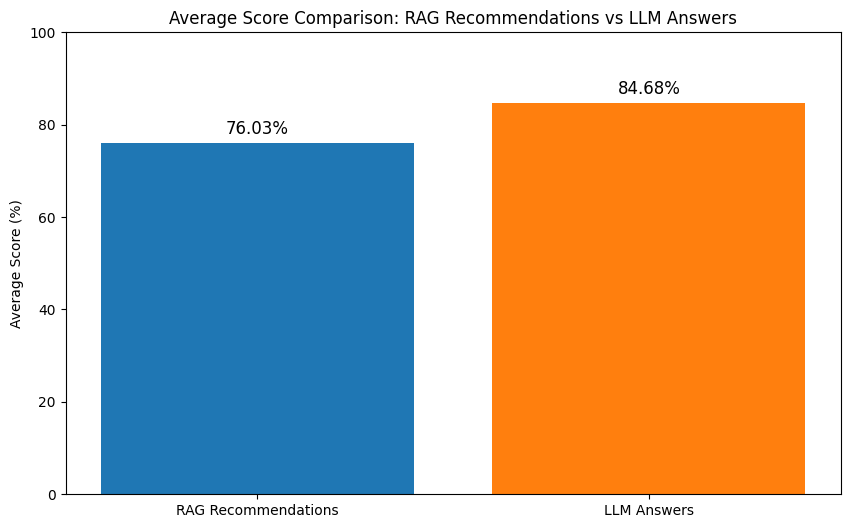

✅ บันทึกผลลัพธ์สรุปที่: /content/drive/MyDrive/LockLearn/evaluation_summary.json


In [2]:
import json
import re
import matplotlib.pyplot as plt

# 📂 โหลดไฟล์ผลลัพธ์การประเมิน
judgement_results_file = '/content/drive/MyDrive/LockLearn/evaluation_judgement_results.json'

with open(judgement_results_file, 'r', encoding='utf-8') as f:
    judgement_results = json.load(f)

# ✅ ฟังก์ชันเพื่อแยกคะแนนจาก judgement
def extract_scores(judgement_text):
    rag_score = llm_score = None

    # ใช้ Regular Expression เพื่อดึงคะแนน
    rag_match = re.search(r"RAG Recommendations Score: (\d)", judgement_text)
    llm_match = re.search(r"LLM Answer Score: (\d)", judgement_text)

    if rag_match:
        rag_score = int(rag_match.group(1))
    if llm_match:
        llm_score = int(llm_match.group(1))

    return rag_score, llm_score

# ✅ สร้างข้อมูลใหม่พร้อมคะแนน
processed_results = []
for item in judgement_results:
    rag_score, llm_score = extract_scores(item.get('judgement', ''))

    if rag_score is not None and llm_score is not None:
        processed_results.append({
            "question": item['question'],
            "ground_truth": item['ground_truth'],
            "recommendations": item['recommendations'],
            "llm_answer": item['llm_answer'],
            "rag_score": rag_score,
            "llm_score": llm_score
        })

# ✅ คำนวณคะแนนเฉลี่ย
total_rag_score = sum(item['rag_score'] for item in processed_results)
total_llm_score = sum(item['llm_score'] for item in processed_results)
num_questions = len(processed_results)

avg_rag_score = (total_rag_score / (num_questions * 5)) * 100  # เปลี่ยนเป็นเปอร์เซ็นต์
avg_llm_score = (total_llm_score / (num_questions * 5)) * 100  # เปลี่ยนเป็นเปอร์เซ็นต์

# ✅ แสดงผลคะแนน
print(f"✅ จำนวนคำถามที่ประเมิน: {num_questions}")
print(f"✅ คะแนนเฉลี่ยของ RAG: {avg_rag_score:.2f}%")
print(f"✅ คะแนนเฉลี่ยของ LLM: {avg_llm_score:.2f}%")

# ✅ สร้างกราฟ
labels = ['RAG Recommendations', 'LLM Answers']
scores = [avg_rag_score, avg_llm_score]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=colors)
plt.title('Average Score Comparison: RAG Recommendations vs LLM Answers')
plt.ylabel('Average Score (%)')
plt.ylim(0, 100)

# 🔧 แสดงคะแนนบนกราฟ
for i, score in enumerate(scores):
    plt.text(i, score + 2, f"{score:.2f}%", ha='center', fontsize=12)

plt.show()

# ✅ บันทึกผลลัพธ์สรุปเป็น JSON
summary_file = '/content/drive/MyDrive/LockLearn/evaluation_summary.json'
summary_data = {
    "average_rag_score": avg_rag_score,
    "average_llm_score": avg_llm_score,
    "detailed_results": processed_results
}

with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump(summary_data, f, ensure_ascii=False, indent=4)

print(f"✅ บันทึกผลลัพธ์สรุปที่: {summary_file}")


ทำการหาค่า Accuracy เเล้ว plot ออกมา (ในกรณีที่เราต้องการ Sccore ≥ 4)

✅ จำนวนคำถามที่ประเมิน: 1351
✅ RAG Accuracy: 81.64% (1103/1351)
✅ LLM Accuracy: 78.09% (1055/1351)


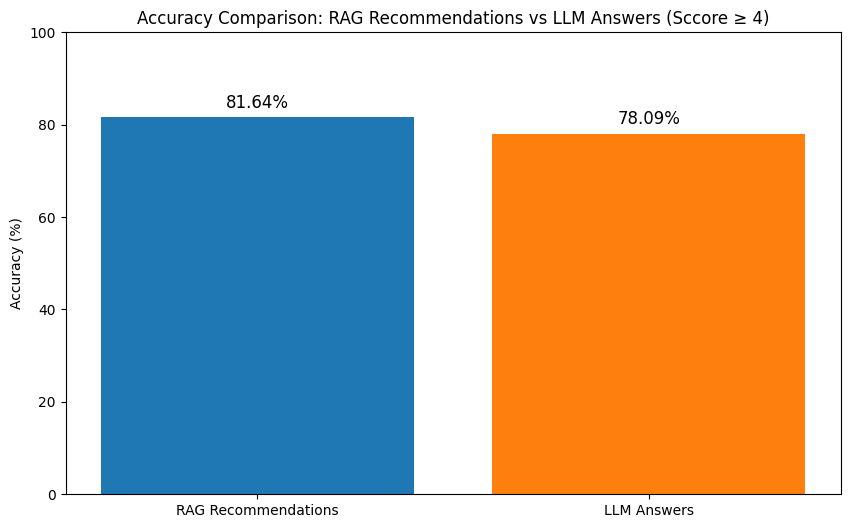

✅ บันทึกผลลัพธ์สรุปที่: /content/drive/MyDrive/LockLearn/accuracy_summary.json


In [3]:
import json
import matplotlib.pyplot as plt

# 🚀 โหลดผลลัพธ์ที่ประเมินแล้ว
summary_file = '/content/drive/MyDrive/LockLearn/evaluation_summary.json'

with open(summary_file, 'r', encoding='utf-8') as f:
    summary_data = json.load(f)

# ✅ ดึงข้อมูลรายละเอียดคำตอบ
detailed_results = summary_data.get("detailed_results", [])

# ✅ กำหนดเกณฑ์ (คะแนน ≥ 4 ถือว่าถูกต้อง)
correct_threshold = 4

# ✅ นับจำนวนคำตอบที่ถูกต้อง
rag_correct = sum(1 for item in detailed_results if item.get('rag_score', 0) >= correct_threshold)
llm_correct = sum(1 for item in detailed_results if item.get('llm_score', 0) >= correct_threshold)
total_questions = len(detailed_results)

# ✅ คำนวณ Accuracy
rag_accuracy = (rag_correct / total_questions) * 100 if total_questions > 0 else 0
llm_accuracy = (llm_correct / total_questions) * 100 if total_questions > 0 else 0

# ✅ แสดงผลลัพธ์
print(f"✅ จำนวนคำถามที่ประเมิน: {total_questions}")
print(f"✅ RAG Accuracy: {rag_accuracy:.2f}% ({rag_correct}/{total_questions})")
print(f"✅ LLM Accuracy: {llm_accuracy:.2f}% ({llm_correct}/{total_questions})")

# ✅ สร้างกราฟเปรียบเทียบ Accuracy
labels = ['RAG Recommendations', 'LLM Answers']
accuracies = [rag_accuracy, llm_accuracy]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=colors)
plt.title('Accuracy Comparison: RAG Recommendations vs LLM Answers (Sccore ≥ 4)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# 🔧 แสดงคะแนนบนกราฟ
for i, score in enumerate(accuracies):
    plt.text(i, score + 2, f"{score:.2f}%", ha='center', fontsize=12)

plt.show()

# ✅ บันทึกผลลัพธ์สรุปเป็น JSON
accuracy_summary_file = '/content/drive/MyDrive/LockLearn/accuracy_summary.json'
accuracy_data = {
    "total_questions": total_questions,
    "rag_accuracy": rag_accuracy,
    "llm_accuracy": llm_accuracy,
    "rag_correct": rag_correct,
    "llm_correct": llm_correct
}

with open(accuracy_summary_file, 'w', encoding='utf-8') as f:
    json.dump(accuracy_data, f, ensure_ascii=False, indent=4)

print(f"✅ บันทึกผลลัพธ์สรุปที่: {accuracy_summary_file}")
